# Tensorboard

Tensorboard is a visualization and inspection tool created by TensorFlow, which can also be integrated with PyTorch to visualize and inspect our pipeline and models. In this notebook, the code is nearly identical to the code from notebook 12: feed forward net. We are using it as an example for how to get started with Tensorboard. <br>

To get started, run tensorboard in the terminal with `tensorboard --logdir=runs` where `logdir` is the directory where run logs are stored. Tensorboard will be started on localhost.

In [12]:
# Import

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [2]:
# Create a summary write for tensorboard
writer = SummaryWriter("runs/mnist")

In [3]:
# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Hyperparameters
input_size = 784  # 28 x 28 is the image size, will be flattened into a 1D tensor
hidden_size = 100  # Number of nodes in the hidden layer
num_classes = 10  # Digits from 0 - 9
num_epochs = 2
batch_size = 100
learning_rate = 0.001

In [5]:
# Import MNIST data
training_dataset = torchvision.datasets.MNIST(root='./data', train=True, 
    transform=transforms.ToTensor(), download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, 
    transform=transforms.ToTensor())

# Create dataloaders
train_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=batch_size,
    shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,
    shuffle=True, num_workers=0)

# View a single batch
examples = iter(train_loader)
samples, labels = examples.next()
print(f'Shape: {samples.shape}, Labels shape: {labels.shape}')

Shape: torch.Size([100, 1, 28, 28]), Labels shape: torch.Size([100])


The size of the sample is 100 (batch size), 1 is for a singular channel (no colour channels), 28, 28 is the image array (28x28). Each class label has 1 value, hence the labels being a tensor of 100.

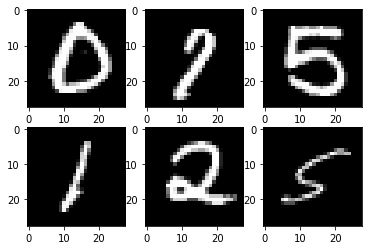

In [6]:
# Plot this
for i in range(6):  # 6 samples
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray')  # [0] for the first color channel
plt.show()

# Apart from plotting we can also add the images to the tensorboard
image_grid = torchvision.utils.make_grid(samples)
writer.add_image("MNIST images example", image_grid)
writer.close()

In [7]:
# Let's create a neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):  # Num classes = output size
        super(NeuralNet, self).__init__()
        # Layers
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()  # Activation function
        self.layer2 = nn.Linear(hidden_size, num_classes)  # Output layer
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        # No softmax as we're applying cross entropy loss
        return out

In [8]:
# Create the model
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and Optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Model graph
sample_data = samples.reshape(-1, 28*28).to(device)
writer.add_graph(model, sample_data)
writer.close()

In [15]:
# Training loop
n_total_steps = len(train_loader)

# Adding Tensorboard diagnostics
running_loss = 0.0
running_correct_preds = 0

print("Reshaping...")
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Reshape the images from 100, 1, 28, 28 to 100, 784
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss_value = loss(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        # Update running metrics
        running_loss += loss_value.item()
        _, predictions = torch.max(outputs, 1)
        running_correct_preds += torch.sum(predictions == labels).sum().item()
        # Print info
        if (i + 1) % 100 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Step {i + 1}/{n_total_steps}, Loss: {loss_value.item():.4f}')
            # Calculate the mean and add it to the tensorboard
            writer.add_scalar('Training Loss', running_loss / 100, epoch * n_total_steps + i)
            writer.add_scalar('Accuracy', running_correct_preds / 100, epoch * n_total_steps + i)
            # Reset
            running_loss = 0.0
            running_correct_preds = 0


# Testing and Evaluation of the model
# Create a list to store labels. This will help in implementing a precision recall curve on tensorboard
diag_labels = []
preds = []

# Don't compute gradients for these steps
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        # Reshape
        images = images.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predictions = torch.max(outputs, 1)  # Along first dimension
        n_samples += labels.shape[0]  # Will give number of samples in current batch
        # n_samples += labels.size(0) is also valid
        n_correct += (predictions == labels).sum().item()

        # Diagnostics
        class_predictions = [F.softmax(output, dim=0) for output in outputs]
        preds.append(class_predictions)
        diag_labels.append(predictions)
        
    # Diagnostic conversion
    diag_labels = torch.cat(diag_labels)  # Concatenate all labels along this dimension into a 1D tensor
    preds = torch.cat([torch.stack(batch) for batch in preds])

    acc = 100.0 * n_correct / n_samples

    print(f'Accuracy: {acc:.4f}%')

    # Add the precision recall curve to tensorboard
    classes = range(10)
    for i in classes:
        labels_i = diag_labels == i
        preds_i = preds[:, i]  # All the samples for class i

        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
        writer.close()

Reshaping...
Epoch 1/2, Step 100/600, Loss: 0.0378
Epoch 1/2, Step 200/600, Loss: 0.0859
Epoch 1/2, Step 300/600, Loss: 0.0469
Epoch 1/2, Step 400/600, Loss: 0.0463
Epoch 1/2, Step 500/600, Loss: 0.0219
Epoch 1/2, Step 600/600, Loss: 0.0175
Epoch 2/2, Step 100/600, Loss: 0.0596
Epoch 2/2, Step 200/600, Loss: 0.0518
Epoch 2/2, Step 300/600, Loss: 0.0712
Epoch 2/2, Step 400/600, Loss: 0.0349
Epoch 2/2, Step 500/600, Loss: 0.0108
Epoch 2/2, Step 600/600, Loss: 0.1143
Accuracy: 97.4900%
